# Imports 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline

from scripts import data_loading
from scripts.models import CrfFeatures
from future.utils import iteritems

In [2]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

In [3]:
import eli5

Using TensorFlow backend.


In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.utils import to_categorical
from sklearn.metrics import classification_report

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

#### Parameters and constants 

In [38]:
PATH = r'C:\Users\Ruslan_Golubev\Documents\local_ds_files\NER - GMB\gmb-2.2.0\data'
tags_file_name = '\en.tags'
source_file_name = '\en.met'
columns = ['raw', 'pos', 'lemma', 'ner_target', 'word_net_pos', 'animacy_tag', 'title', 'date', 'genre', 'n_sent']
SEED = 77

# Data loading

In [39]:
data = data_loading.many_folders(PATH, source_file_name, tags_file_name, columns)

10000it [00:08, 1221.25it/s]


In [40]:
data['ner_target'] = data['ner_target'].apply(lambda x: x.split('-')[0])
tags_df = data[['raw', 'pos', 'lemma', 'ner_target', 'title', 'n_sent']]

In [41]:
tags_df.head()

,raw,pos,lemma,ner_target,title,n_sent
0,Thousands,NNS,thousand,O,Thousands Protest Iraq War in London,0
1,of,IN,of,O,Thousands Protest Iraq War in London,0
2,demonstrators,NNS,demonstrator,O,Thousands Protest Iraq War in London,0
3,have,VBP,have,O,Thousands Protest Iraq War in London,0
4,marched,VBN,march,O,Thousands Protest Iraq War in London,0


In [42]:
tags_df.shape

(1231279, 6)

# EDA

In [43]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231279 entries, 0 to 1231278
Data columns (total 6 columns):
raw           1231279 non-null object
pos           1231279 non-null object
lemma         1231279 non-null object
ner_target    1231279 non-null object
title         1231279 non-null object
n_sent        1231279 non-null int64
dtypes: int64(1), object(5)
memory usage: 56.4+ MB


In [44]:
corpus = data_loading.get_sent(tags_df)

In [45]:
sents = []
for i in corpus:
    sents.append(data_loading.bio_tags(i))

In [46]:
tags_df['tags'] = [i[2] for j in sents for i in j]

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
words = list(set(tags_df["raw"].values))
n_words = len(words)
print(n_words)

35153


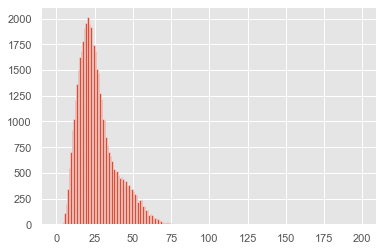

In [48]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sents], bins=[i for i in range(200)])
plt.show()

In [49]:
maxlen = max([len(s) for s in sents])
print ('Maximum sent length:', maxlen)

Maximum sent length: 92


In [50]:
sents[0]

[('Thousands', 'NNS', 'O', 'thousand'),
 ('of', 'IN', 'O', 'of'),
 ('demonstrators', 'NNS', 'O', 'demonstrator'),
 ('have', 'VBP', 'O', 'have'),
 ('marched', 'VBN', 'O', 'march'),
 ('through', 'IN', 'O', 'through'),
 ('London', 'NNP', 'B-geo', 'london'),
 ('to', 'TO', 'O', 'to'),
 ('protest', 'VB', 'O', 'protest'),
 ('the', 'DT', 'O', 'the'),
 ('war', 'NN', 'O', 'war'),
 ('in', 'IN', 'O', 'in'),
 ('Iraq', 'NNP', 'B-geo', 'iraq'),
 ('and', 'CC', 'O', 'and'),
 ('demand', 'VB', 'O', 'demand'),
 ('the', 'DT', 'O', 'the'),
 ('withdrawal', 'NN', 'O', 'withdrawal'),
 ('of', 'IN', 'O', 'of'),
 ('British', 'JJ', 'B-gpe', 'uk'),
 ('troops', 'NNS', 'O', 'troops'),
 ('from', 'IN', 'O', 'from'),
 ('that', 'DT', 'O', 'that'),
 ('country', 'NN', 'O', 'country'),
 ('.', '.', 'O', '.')]

In [51]:
for tag in tags_df.ner_target.unique():
    print('Words with tag', tag,'\n', tags_df.loc[tags_df['ner_target'] == tag, 'raw'].head())

Words with tag O 
 0        Thousands
1               of
2    demonstrators
3             have
4          marched
Name: raw, dtype: object
Words with tag geo 
 6      London
12       Iraq
65       Hyde
66       Park
94    Britain
Name: raw, dtype: object
Words with tag gpe 
 18     British
102    English
113    Britain
126    British
173       Iran
Name: raw, dtype: object
Words with tag per 
 42            Bush
270      President
271        Mahmoud
272    Ahmadinejad
331         Thomas
Name: raw, dtype: object
Words with tag org 
 97             Labor
98             Party
154    International
155           Atomic
156           Energy
Name: raw, dtype: object
Words with tag tim 
 167    Wednesday
211    Wednesday
274      Tuesday
341    Wednesday
493    Wednesday
Name: raw, dtype: object
Words with tag art 
 263               Nuclear
264     Non-Proliferation
3769             Saltillo
3810            Pentastar
3811                  V-6
Name: raw, dtype: object
Words with tag nat 
 2723

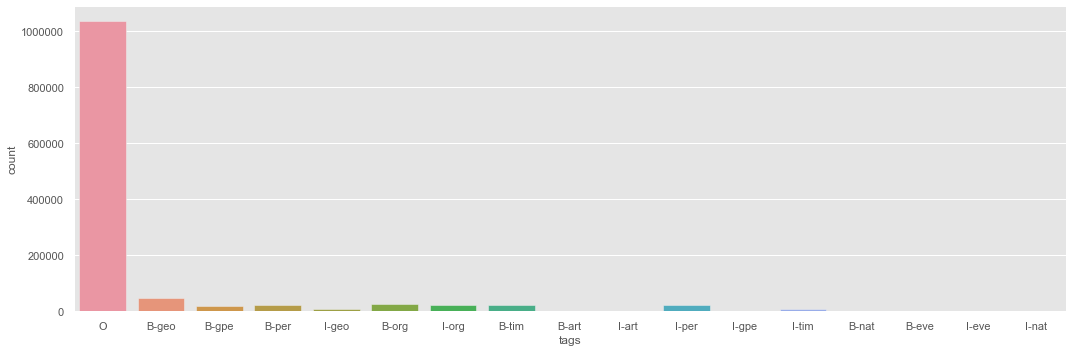

In [52]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tags', data=tags_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

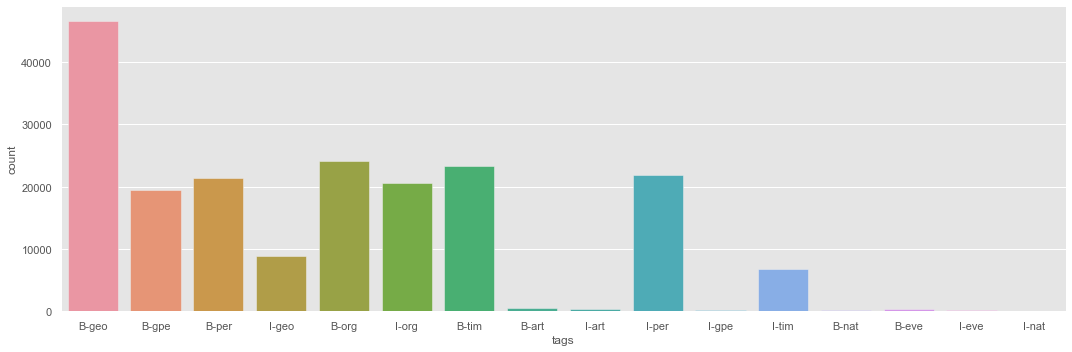

In [53]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tags', data=tags_df.loc[data['ner_target'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

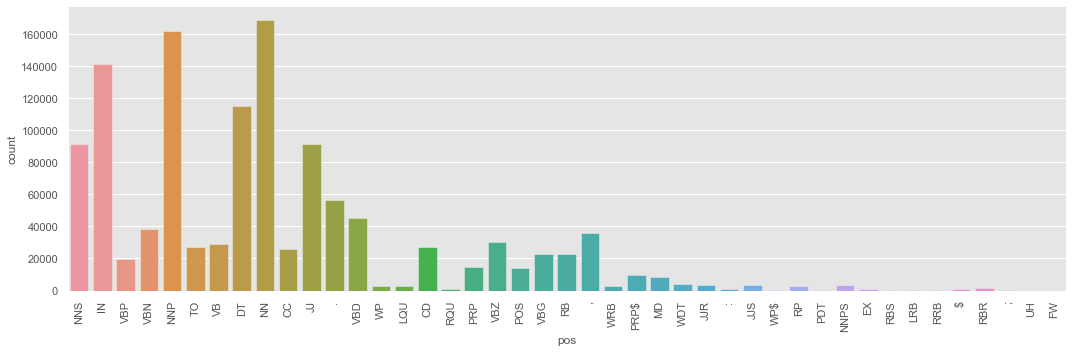

In [54]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('pos', data=tags_df, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# HMM

In [7]:
from hmmlearn import hmm

In [31]:
class ModifiedHMM(hmm.MultinomialHMM):
    def rr(self):
        return rr

In [35]:
import numpy as np

model = ModifiedHMM(n_components=3)
model.startprob_ = np.array([0.3, 0.4, 0.3])
model.transmat_ = np.array([[0.2, 0.6, 0.2],
                            [0.4, 0.0, 0.6],
                            [0.1, 0.2, 0.7]])
model.emissionprob_ = np.array([[0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                                [0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1],
                                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]])

# Predict the optimal sequence of internal hidden state
X = np.atleast_2d([3, 4, 5, 6, 7]).T
print(model.decode(X))

(-13.758752224145665, array([0, 1, 2, 2, 2]))


In [30]:
hmm.MultinomialHMM

hmmlearn.hmm.MultinomialHMM

In [79]:
sent = tags_df[tags_df['n_sent']==0]['raw'].values

In [83]:
def encoder(sent):
    enc_sent = [word2idx[key] for key in sent]
    return enc_sent
encoder(sent)

[15694,
 15663,
 2845,
 5843,
 16443,
 3670,
 5002,
 28672,
 12476,
 1199,
 33020,
 2120,
 24930,
 25934,
 10980,
 1199,
 18288,
 15663,
 3672,
 33140,
 14488,
 24976,
 20003,
 11373]

In [60]:
tags_df[tags_df['n_sent']==0]['tags'].values

array(['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O',
       'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'],
      dtype=object)

In [113]:
from tqdm import tqdm


In [138]:
!pip install collections

  ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [199]:
corpus = [' '.join(sent) for sent in corpus]

In [200]:
corpus

['Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "',
 'They marched from the Houses of Parliament to a rally in Hyde Park .',
 'Police put the number of marchers at 10,000 while organizers claimed it was 100,000 .',
 "The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton .",
 "The party is divided over Britain 's participation in the Iraq conflict and the continued deployment of 8,500 British troops in that country .",
 "The London march came ahead of anti-war protests today in other cities , including Rome , Paris , and Madrid . The International Atomic Energy Agency is to hold second day of talks in Vienna Wednesday on how to respond to Ira

In [216]:
from collections import defaultdict
dic = defaultdict(lambda: defaultdict(lambda: 0)) 

In [188]:
tokenized = list(map(nltk.word_tokenize, corpus))

In [210]:
corpus = [list(nltk.ngrams([word for word in sent], n = 1)) for sent in corpus]

In [211]:
corpus

[[('Thousands',),
  ('of',),
  ('demonstrators',),
  ('have',),
  ('marched',),
  ('through',),
  ('London',),
  ('to',),
  ('protest',),
  ('the',),
  ('war',),
  ('in',),
  ('Iraq',),
  ('and',),
  ('demand',),
  ('the',),
  ('withdrawal',),
  ('of',),
  ('British',),
  ('troops',),
  ('from',),
  ('that',),
  ('country',),
  ('.',)],
 [('Families',),
  ('of',),
  ('soldiers',),
  ('killed',),
  ('in',),
  ('the',),
  ('conflict',),
  ('joined',),
  ('the',),
  ('protesters',),
  ('who',),
  ('carried',),
  ('banners',),
  ('with',),
  ('such',),
  ('slogans',),
  ('as',),
  ('"',),
  ('Bush',),
  ('Number',),
  ('One',),
  ('Terrorist',),
  ('"',),
  ('and',),
  ('"',),
  ('Stop',),
  ('the',),
  ('Bombings',),
  ('.',),
  ('"',)],
 [('They',),
  ('marched',),
  ('from',),
  ('the',),
  ('Houses',),
  ('of',),
  ('Parliament',),
  ('to',),
  ('a',),
  ('rally',),
  ('in',),
  ('Hyde',),
  ('Park',),
  ('.',)],
 [('Police',),
  ('put',),
  ('the',),
  ('number',),
  ('of',),
  ('marc

In [194]:
list(ngram)

[('Thousands',),
 ('of',),
 ('demonstrators',),
 ('have',),
 ('marched',),
 ('through',),
 ('London',),
 ('to',),
 ('protest',),
 ('the',),
 ('war',),
 ('in',),
 ('Iraq',),
 ('and',),
 ('demand',),
 ('the',),
 ('withdrawal',),
 ('of',),
 ('British',),
 ('troops',),
 ('from',),
 ('that',),
 ('country',),
 ('.',)]

In [217]:
for ngram in [item for sublist in corpus for item in sublist]:
            dic[ngram[:-1]][ngram[-1]] += 1
        #print(ngram)

dict_keys([()])

In [149]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ruslan_Golubev\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
M = np.zeros((len(word2idx), len(word2idx)))

for (i,j) in zip(T,T[1:]):
    M[i][j] += 1


In [129]:

#now convert to probabilities:
for row in M:
    n = sum(row)
    if n > 0:
        row[:] = [f/sum(row) for f in row]

#print M:

for row in M:
    print(row)

KeyboardInterrupt: 

In [98]:
for (i,j) in zip(T,T[1:]):
    print(i,j)

15694 15663
15663 2845
2845 5843
5843 16443
16443 3670
3670 5002
5002 28672
28672 12476
12476 1199
1199 33020
33020 2120
2120 24930
24930 25934
25934 10980
10980 1199
1199 18288
18288 15663
15663 3672
3672 33140
33140 14488
14488 24976
24976 20003
20003 11373


In [63]:
m = transition_matrix(t)
for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [68]:
ord('A')

65

In [69]:
ord('D')

68

# CRF

In [23]:
features = CrfFeatures()
X, y = features.run(sents)

In [90]:
X[0]

array([25252, 26365,  4804, 19731, 31613, 33112, 26356, 28067, 27573,
       26769, 24030,  6572,  1071,  7484, 12400, 26769,  7315, 26365,
       16820,  8699, 11495,  9021, 24495, 23462, 35152, 35152, 35152,
       35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152,
       35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152,
       35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152,
       35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152, 35152,
       35152, 35152, 35152, 35152, 35152, 35152, 35152])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)

In [26]:
crf = CRF(algorithm='lbfgs',
         c1=0.1,
         c2=0.1,
         max_iterations=100,
         all_possible_transitions=False)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [27]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-tim',
 'B-gpe',
 'B-org',
 'B-geo',
 'B-per',
 'I-per',
 'I-org',
 'I-geo',
 'B-art',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat',
 'I-art',
 'I-gpe']

In [42]:
y_pred = crf.predict(X_test)
sorted_labels = sorted(labels,
                       key=lambda name: (name[1:], name[0]))

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

       B-art      0.464     0.194     0.274        67
       I-art      0.455     0.172     0.250        58
       B-eve      0.458     0.262     0.333        42
       I-eve      0.190     0.129     0.154        31
       B-geo      0.867     0.919     0.892      6958
       I-geo      0.808     0.826     0.817      1270
       B-gpe      0.977     0.948     0.962      2918
       I-gpe      0.818     0.346     0.486        26
       B-nat      0.667     0.296     0.410        27
       I-nat      0.600     0.600     0.600         5
       B-org      0.826     0.746     0.784      3683
       I-org      0.823     0.795     0.809      2983
       B-per      0.866     0.856     0.861      3142
       I-per      0.856     0.908     0.881      3234
       B-tim      0.932     0.885     0.908      3466
       I-tim      0.838     0.763     0.799       998

   micro avg      0.869     0.859     0.864     28908
   macro avg      0.715   

In [50]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.867,1.225,0.0,1.424,0.0,2.178,0.0,1.133,0.0,1.027,0.0,1.926,0.0,4.138,0.0,2.535,0.0
B-art,-0.422,0.0,8.212,0.0,0.0,-0.113,0.0,0.0,0.0,0.0,0.0,0.935,0.0,-0.434,0.0,0.322,0.0
I-art,-1.449,0.0,7.39,0.0,0.0,-0.727,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.527,0.0,-1.194,0.0
B-eve,-0.447,0.0,0.0,0.0,8.302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.169,0.0
I-eve,-0.114,0.0,0.0,0.0,8.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.362,0.0
B-geo,0.417,0.594,0.0,0.352,0.0,0.0,7.857,0.605,0.0,0.0,0.0,0.606,0.0,0.668,0.0,2.109,0.0
I-geo,-0.361,1.331,0.0,0.0,0.0,0.0,6.686,-0.993,0.0,0.0,0.0,-0.169,0.0,1.083,0.0,1.043,0.0
B-gpe,0.638,-0.547,0.0,-0.238,0.0,0.587,0.0,0.0,8.254,0.0,0.0,1.779,0.0,1.532,0.0,0.474,0.0
I-gpe,-0.769,0.0,0.0,0.0,0.0,-0.029,0.0,0.0,5.433,0.0,0.0,0.0,0.0,0.588,0.0,0.0,0.0
B-nat,-0.517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.608,0.0,0.0,0.217,0.0,0.046,0.0


In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [60]:
len(labels)

16

In [61]:
labels

['B-tim',
 'B-gpe',
 'B-org',
 'B-geo',
 'B-per',
 'I-per',
 'I-org',
 'I-geo',
 'B-art',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat',
 'I-art',
 'I-gpe']

In [63]:
tags_df.ner_target.unique()

array(['O', 'geo', 'gpe', 'per', 'org', 'tim', 'art', 'nat', 'eve'],
      dtype=object)

# Bi-lstm

In [30]:
tags = ['unk', 'O']
tags = tags + labels

In [31]:
n_tags = len(tags)

In [32]:
len(words)

35153

In [73]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

NameError: name 'tags' is not defined

In [75]:
word2idx = {w: i for i, w in enumerate(words)}

In [36]:
X = [[word2idx[w[0]] for w in s] for s in sents]

In [37]:
X = pad_sequences(maxlen=70, sequences=X, padding="post", value=n_words - 1)

In [38]:
y_idx = [[tag2idx[w[2]] for w in s] for s in sents]
print(sents[0])
print(y_idx[0])

[('Thousands', 'NNS', 'O', 'thousand'), ('of', 'IN', 'O', 'of'), ('demonstrators', 'NNS', 'O', 'demonstrator'), ('have', 'VBP', 'O', 'have'), ('marched', 'VBN', 'O', 'march'), ('through', 'IN', 'O', 'through'), ('London', 'NNP', 'B-geo', 'london'), ('to', 'TO', 'O', 'to'), ('protest', 'VB', 'O', 'protest'), ('the', 'DT', 'O', 'the'), ('war', 'NN', 'O', 'war'), ('in', 'IN', 'O', 'in'), ('Iraq', 'NNP', 'B-geo', 'iraq'), ('and', 'CC', 'O', 'and'), ('demand', 'VB', 'O', 'demand'), ('the', 'DT', 'O', 'the'), ('withdrawal', 'NN', 'O', 'withdrawal'), ('of', 'IN', 'O', 'of'), ('British', 'JJ', 'B-gpe', 'uk'), ('troops', 'NNS', 'O', 'troops'), ('from', 'IN', 'O', 'from'), ('that', 'DT', 'O', 'that'), ('country', 'NN', 'O', 'country'), ('.', '.', 'O', '.')]
[1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1]


In [39]:
y = pad_sequences(maxlen=70, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[100])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [40]:

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [52]:
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=200, input_length=70))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="relu")))
crf_layer = CRF(n_tags)
model.add(crf_layer)

In [93]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 200)           7030800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 200)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 70, 256)           336896    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 18)            4626      
_________________________________________________________________
crf_1 (CRF)                  (None, 70, 18)            702       
Total params: 7,373,024
Trainable params: 7,373,024
Non-trainable params: 0
_________________________________________________________________


In [54]:
# adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [56]:
history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=20,
                    validation_split=0.1, verbose=1)

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 36499 samples, validate on 4056 samples
Epoch 1/20


18560/36499 [==============>...............] - ETA: 7:25 - loss: 2.9203 - crf_viterbi_accuracy: 0.00 - ETA: 5:45 - loss: 2.8939 - crf_viterbi_accuracy: 0.00 - ETA: 5:13 - loss: 2.8680 - crf_viterbi_accuracy: 0.00 - ETA: 4:56 - loss: 2.8380 - crf_viterbi_accuracy: 0.00 - ETA: 4:47 - loss: 2.8011 - crf_viterbi_accuracy: 0.00 - ETA: 4:42 - loss: 2.7545 - crf_viterbi_accuracy: 0.03 - ETA: 4:38 - loss: 2.6886 - crf_viterbi_accuracy: 0.12 - ETA: 4:36 - loss: 2.6040 - crf_viterbi_accuracy: 0.21 - ETA: 4:33 - loss: 2.4989 - crf_viterbi_accuracy: 0.29 - ETA: 4:31 - loss: 2.3817 - crf_viterbi_accuracy: 0.35 - ETA: 4:30 - loss: 2.2620 - crf_viterbi_accuracy: 0.41 - ETA: 4:30 - loss: 2.1465 - crf_viterbi_accuracy: 0.45 - ETA: 4:28 - loss: 2.0373 - crf_viterbi_accuracy: 0.49 - ETA: 4:28 - loss: 1.9359 - crf_viterbi_accuracy: 0.52 - ETA: 4:26 - loss: 1.8458 - crf_viterbi_accuracy: 0.55 - ETA: 4:25 - loss: 1.7664 - crf_viterbi_accuracy: 0.57 - ETA: 4:24 - loss: 1.6955 - crf_viterbi_accuracy: 0.59 - E

18688/36499 [==============>...............] - ETA: 5:40 - loss: 0.1123 - crf_viterbi_accuracy: 0.96 - ETA: 5:39 - loss: 0.1059 - crf_viterbi_accuracy: 0.96 - ETA: 5:39 - loss: 0.1051 - crf_viterbi_accuracy: 0.96 - ETA: 5:39 - loss: 0.1056 - crf_viterbi_accuracy: 0.96 - ETA: 5:38 - loss: 0.1068 - crf_viterbi_accuracy: 0.96 - ETA: 5:38 - loss: 0.1062 - crf_viterbi_accuracy: 0.96 - ETA: 5:36 - loss: 0.1089 - crf_viterbi_accuracy: 0.96 - ETA: 5:33 - loss: 0.1087 - crf_viterbi_accuracy: 0.96 - ETA: 5:33 - loss: 0.1105 - crf_viterbi_accuracy: 0.96 - ETA: 5:31 - loss: 0.1088 - crf_viterbi_accuracy: 0.96 - ETA: 5:30 - loss: 0.1071 - crf_viterbi_accuracy: 0.96 - ETA: 5:30 - loss: 0.1067 - crf_viterbi_accuracy: 0.96 - ETA: 5:30 - loss: 0.1072 - crf_viterbi_accuracy: 0.96 - ETA: 5:29 - loss: 0.1067 - crf_viterbi_accuracy: 0.96 - ETA: 5:28 - loss: 0.1076 - crf_viterbi_accuracy: 0.96 - ETA: 5:26 - loss: 0.1067 - crf_viterbi_accuracy: 0.96 - ETA: 5:25 - loss: 0.1066 - crf_viterbi_accuracy: 0.96 - E

36499/36499 [==============================] - ETA: 2:52 - loss: 0.0879 - crf_viterbi_accuracy: 0.97 - ETA: 2:51 - loss: 0.0877 - crf_viterbi_accuracy: 0.97 - ETA: 2:50 - loss: 0.0876 - crf_viterbi_accuracy: 0.97 - ETA: 2:49 - loss: 0.0875 - crf_viterbi_accuracy: 0.97 - ETA: 2:48 - loss: 0.0874 - crf_viterbi_accuracy: 0.97 - ETA: 2:47 - loss: 0.0873 - crf_viterbi_accuracy: 0.97 - ETA: 2:45 - loss: 0.0872 - crf_viterbi_accuracy: 0.97 - ETA: 2:44 - loss: 0.0871 - crf_viterbi_accuracy: 0.97 - ETA: 2:43 - loss: 0.0869 - crf_viterbi_accuracy: 0.97 - ETA: 2:42 - loss: 0.0868 - crf_viterbi_accuracy: 0.97 - ETA: 2:40 - loss: 0.0868 - crf_viterbi_accuracy: 0.97 - ETA: 2:39 - loss: 0.0867 - crf_viterbi_accuracy: 0.97 - ETA: 2:38 - loss: 0.0865 - crf_viterbi_accuracy: 0.97 - ETA: 2:37 - loss: 0.0864 - crf_viterbi_accuracy: 0.97 - ETA: 2:35 - loss: 0.0862 - crf_viterbi_accuracy: 0.97 - ETA: 2:34 - loss: 0.0860 - crf_viterbi_accuracy: 0.97 - ETA: 2:33 - loss: 0.0860 - crf_viterbi_accuracy: 0.97 - E

18688/36499 [==============>...............] - ETA: 5:30 - loss: 0.0398 - crf_viterbi_accuracy: 0.98 - ETA: 5:33 - loss: 0.0385 - crf_viterbi_accuracy: 0.98 - ETA: 5:39 - loss: 0.0397 - crf_viterbi_accuracy: 0.98 - ETA: 5:41 - loss: 0.0412 - crf_viterbi_accuracy: 0.98 - ETA: 5:41 - loss: 0.0412 - crf_viterbi_accuracy: 0.98 - ETA: 5:40 - loss: 0.0411 - crf_viterbi_accuracy: 0.98 - ETA: 5:38 - loss: 0.0415 - crf_viterbi_accuracy: 0.98 - ETA: 5:36 - loss: 0.0413 - crf_viterbi_accuracy: 0.98 - ETA: 5:35 - loss: 0.0409 - crf_viterbi_accuracy: 0.98 - ETA: 5:33 - loss: 0.0408 - crf_viterbi_accuracy: 0.98 - ETA: 5:32 - loss: 0.0416 - crf_viterbi_accuracy: 0.98 - ETA: 5:31 - loss: 0.0409 - crf_viterbi_accuracy: 0.98 - ETA: 5:30 - loss: 0.0412 - crf_viterbi_accuracy: 0.98 - ETA: 5:30 - loss: 0.0416 - crf_viterbi_accuracy: 0.98 - ETA: 5:28 - loss: 0.0417 - crf_viterbi_accuracy: 0.98 - ETA: 5:27 - loss: 0.0420 - crf_viterbi_accuracy: 0.98 - ETA: 5:26 - loss: 0.0419 - crf_viterbi_accuracy: 0.98 - E

18688/36499 [==============>...............] - ETA: 5:45 - loss: 0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 5:41 - loss: 0.0175 - crf_viterbi_accuracy: 0.99 - ETA: 5:38 - loss: 0.0213 - crf_viterbi_accuracy: 0.98 - ETA: 5:36 - loss: 0.0192 - crf_viterbi_accuracy: 0.98 - ETA: 5:35 - loss: 0.0198 - crf_viterbi_accuracy: 0.98 - ETA: 5:34 - loss: 0.0192 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0189 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0196 - crf_viterbi_accuracy: 0.98 - ETA: 5:34 - loss: 0.0206 - crf_viterbi_accuracy: 0.98 - ETA: 5:34 - loss: 0.0206 - crf_viterbi_accuracy: 0.98 - ETA: 5:33 - loss: 0.0210 - crf_viterbi_accuracy: 0.98 - ETA: 5:31 - loss: 0.0216 - crf_viterbi_accuracy: 0.98 - ETA: 5:30 - loss: 0.0211 - crf_viterbi_accuracy: 0.98 - ETA: 5:29 - loss: 0.0217 - crf_viterbi_accuracy: 0.98 - ETA: 5:28 - loss: 0.0217 - crf_viterbi_accuracy: 0.98 - ETA: 5:26 - loss: 0.0212 - crf_viterbi_accuracy: 0.98 - ETA: 5:26 - loss: 0.0215 - crf_viterbi_accuracy: 0.98 - E

36499/36499 [==============================] - ETA: 2:49 - loss: 0.0191 - crf_viterbi_accuracy: 0.98 - ETA: 2:48 - loss: 0.0191 - crf_viterbi_accuracy: 0.98 - ETA: 2:47 - loss: 0.0191 - crf_viterbi_accuracy: 0.98 - ETA: 2:46 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:45 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:43 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:42 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:41 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:40 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:39 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:38 - loss: 0.0189 - crf_viterbi_accuracy: 0.98 - ETA: 2:37 - loss: 0.0189 - crf_viterbi_accuracy: 0.98 - ETA: 2:35 - loss: 0.0189 - crf_viterbi_accuracy: 0.98 - ETA: 2:34 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - ETA: 2:33 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - ETA: 2:32 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - ETA: 2:31 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - E

18688/36499 [==============>...............] - ETA: 5:59 - loss: 0.0080 - crf_viterbi_accuracy: 0.99 - ETA: 6:11 - loss: 0.0084 - crf_viterbi_accuracy: 0.99 - ETA: 6:17 - loss: 0.0088 - crf_viterbi_accuracy: 0.99 - ETA: 6:18 - loss: 0.0105 - crf_viterbi_accuracy: 0.99 - ETA: 6:18 - loss: 0.0113 - crf_viterbi_accuracy: 0.99 - ETA: 6:16 - loss: 0.0122 - crf_viterbi_accuracy: 0.99 - ETA: 6:12 - loss: 0.0114 - crf_viterbi_accuracy: 0.99 - ETA: 6:11 - loss: 0.0118 - crf_viterbi_accuracy: 0.99 - ETA: 6:09 - loss: 0.0117 - crf_viterbi_accuracy: 0.99 - ETA: 6:09 - loss: 0.0109 - crf_viterbi_accuracy: 0.99 - ETA: 6:10 - loss: 0.0110 - crf_viterbi_accuracy: 0.99 - ETA: 6:10 - loss: 0.0107 - crf_viterbi_accuracy: 0.99 - ETA: 6:09 - loss: 0.0108 - crf_viterbi_accuracy: 0.99 - ETA: 6:08 - loss: 0.0108 - crf_viterbi_accuracy: 0.99 - ETA: 6:07 - loss: 0.0111 - crf_viterbi_accuracy: 0.99 - ETA: 6:05 - loss: 0.0107 - crf_viterbi_accuracy: 0.99 - ETA: 6:03 - loss: 0.0104 - crf_viterbi_accuracy: 0.99 - E

17792/36499 [=============>................] - ETA: 5:32 - loss: 0.0016 - crf_viterbi_accuracy: 0.99 - ETA: 5:33 - loss: 0.0027 - crf_viterbi_accuracy: 0.99 - ETA: 5:35 - loss: 2.5117e-04 - crf_viterbi_accuracy: 0.99 - ETA: 5:36 - loss: 3.8512e-04 - crf_viterbi_accuracy: 0.99 - ETA: 5:35 - loss: 2.8645e-04 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0016 - crf_viterbi_accuracy: 0.9912   - ETA: 5:34 - loss: 0.0017 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0026 - crf_viterbi_accuracy: 0.99 - ETA: 5:33 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 5:32 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 5:31 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 5:30 - loss: 0.0020 - crf_viterbi_accuracy: 0.99 - ETA: 5:28 - loss: 0.0015 - crf_viterbi_accuracy: 0.99 - ETA: 5:28 - loss: 0.0014 - crf_viterbi_accuracy: 0.99 - ETA: 5:26 - loss: 0.0015 - crf_viterbi_accuracy: 0.99 - ETA: 5:26 - loss: 0.0010 - crf_viterbi_accuracy: 0.99 - ETA: 5:25 - loss: 0.0012 - crf_viterbi_ac

35072/36499 [===========================>..] - ETA: 2:59 - loss: 6.3897e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:57 - loss: 6.0498e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:56 - loss: 5.6409e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:55 - loss: 5.7235e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:54 - loss: 5.7738e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:52 - loss: 5.9263e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:51 - loss: 6.1906e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:50 - loss: 6.8670e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:49 - loss: 6.8029e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:47 - loss: 6.3041e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:46 - loss: 5.8088e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:45 - loss: 5.7297e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:44 - loss: 6.1180e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:42 - loss: 6.1341e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:41 - loss: 6.0850e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:40 - loss: 5.8625e-04 - crf_viterbi_accuracy: 

36499/36499 [==============================] - ETA: 12s - loss: -4.6796e-04 - crf_viterbi_accuracy: 0.99 - ETA: 11s - loss: -4.9521e-04 - crf_viterbi_accuracy: 0.99 - ETA: 10s - loss: -5.1039e-04 - crf_viterbi_accuracy: 0.99 - ETA: 8s - loss: -5.2753e-04 - crf_viterbi_accuracy: 0.9914 - ETA: 7s - loss: -5.3917e-04 - crf_viterbi_accuracy: 0.991 - ETA: 6s - loss: -5.5555e-04 - crf_viterbi_accuracy: 0.991 - ETA: 5s - loss: -5.6196e-04 - crf_viterbi_accuracy: 0.991 - ETA: 3s - loss: -5.6605e-04 - crf_viterbi_accuracy: 0.991 - ETA: 2s - loss: -5.5131e-04 - crf_viterbi_accuracy: 0.991 - ETA: 1s - loss: -5.5078e-04 - crf_viterbi_accuracy: 0.991 - ETA: 0s - loss: -5.4742e-04 - crf_viterbi_accuracy: 0.991 - 361s 10ms/step - loss: -5.5098e-04 - crf_viterbi_accuracy: 0.9914 - val_loss: 0.0069 - val_crf_viterbi_accuracy: 0.9881
Epoch 7/20


18048/36499 [=============>................] - ETA: 5:49 - loss: -0.0069 - crf_viterbi_accuracy: 0.992 - ETA: 5:49 - loss: -0.0062 - crf_viterbi_accuracy: 0.993 - ETA: 5:51 - loss: -0.0067 - crf_viterbi_accuracy: 0.992 - ETA: 5:50 - loss: -0.0054 - crf_viterbi_accuracy: 0.992 - ETA: 5:48 - loss: -0.0054 - crf_viterbi_accuracy: 0.992 - ETA: 5:46 - loss: -0.0058 - crf_viterbi_accuracy: 0.992 - ETA: 5:45 - loss: -0.0060 - crf_viterbi_accuracy: 0.992 - ETA: 5:45 - loss: -0.0063 - crf_viterbi_accuracy: 0.992 - ETA: 5:44 - loss: -0.0064 - crf_viterbi_accuracy: 0.992 - ETA: 5:43 - loss: -0.0062 - crf_viterbi_accuracy: 0.992 - ETA: 5:41 - loss: -0.0060 - crf_viterbi_accuracy: 0.992 - ETA: 5:40 - loss: -0.0061 - crf_viterbi_accuracy: 0.992 - ETA: 5:38 - loss: -0.0066 - crf_viterbi_accuracy: 0.992 - ETA: 5:37 - loss: -0.0064 - crf_viterbi_accuracy: 0.992 - ETA: 5:36 - loss: -0.0067 - crf_viterbi_accuracy: 0.992 - ETA: 5:34 - loss: -0.0061 - crf_viterbi_accuracy: 0.992 - ETA: 5:33 - loss: -0.0060

36499/36499 [==============================] - ETA: 0s - loss: -0.0072 - crf_viterbi_accuracy: 0.992 - 365s 10ms/step - loss: -0.0072 - crf_viterbi_accuracy: 0.9920 - val_loss: 0.0024 - val_crf_viterbi_accuracy: 0.9882
Epoch 8/20


18048/36499 [=============>................] - ETA: 5:42 - loss: -0.0135 - crf_viterbi_accuracy: 0.991 - ETA: 5:41 - loss: -0.0104 - crf_viterbi_accuracy: 0.991 - ETA: 5:42 - loss: -0.0106 - crf_viterbi_accuracy: 0.992 - ETA: 5:44 - loss: -0.0100 - crf_viterbi_accuracy: 0.992 - ETA: 5:44 - loss: -0.0099 - crf_viterbi_accuracy: 0.991 - ETA: 5:44 - loss: -0.0101 - crf_viterbi_accuracy: 0.992 - ETA: 5:43 - loss: -0.0099 - crf_viterbi_accuracy: 0.992 - ETA: 5:43 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:41 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:40 - loss: -0.0100 - crf_viterbi_accuracy: 0.992 - ETA: 5:39 - loss: -0.0100 - crf_viterbi_accuracy: 0.992 - ETA: 5:38 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:37 - loss: -0.0094 - crf_viterbi_accuracy: 0.991 - ETA: 5:36 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:34 - loss: -0.0095 - crf_viterbi_accuracy: 0.992 - ETA: 5:34 - loss: -0.0096 - crf_viterbi_accuracy: 0.992 - ETA: 5:32 - loss: -0.0100

36499/36499 [==============================] - ETA: 0s - loss: -0.0132 - crf_viterbi_accuracy: 0.992 - 368s 10ms/step - loss: -0.0132 - crf_viterbi_accuracy: 0.9924 - val_loss: -0.0029 - val_crf_viterbi_accuracy: 0.9882
Epoch 9/20


18048/36499 [=============>................] - ETA: 5:54 - loss: -0.0185 - crf_viterbi_accuracy: 0.995 - ETA: 5:56 - loss: -0.0180 - crf_viterbi_accuracy: 0.993 - ETA: 5:55 - loss: -0.0182 - crf_viterbi_accuracy: 0.993 - ETA: 5:54 - loss: -0.0178 - crf_viterbi_accuracy: 0.993 - ETA: 5:50 - loss: -0.0178 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0180 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0183 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0181 - crf_viterbi_accuracy: 0.993 - ETA: 5:46 - loss: -0.0182 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0184 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0183 - crf_viterbi_accuracy: 0.993 - ETA: 5:43 - loss: -0.0178 - crf_viterbi_accuracy: 0.993 - ETA: 5:41 - loss: -0.0179 - crf_viterbi_accuracy: 0.993 - ETA: 5:40 - loss: -0.0174 - crf_viterbi_accuracy: 0.993 - ETA: 5:39 - loss: -0.0175 - crf_viterbi_accuracy: 0.993 - ETA: 5:37 - loss: -0.0169 - crf_viterbi_accuracy: 0.993 - ETA: 5:36 - loss: -0.0170

36499/36499 [==============================] - ETA: 0s - loss: -0.0189 - crf_viterbi_accuracy: 0.992 - 367s 10ms/step - loss: -0.0189 - crf_viterbi_accuracy: 0.9929 - val_loss: -0.0067 - val_crf_viterbi_accuracy: 0.9883
Epoch 10/20


18048/36499 [=============>................] - ETA: 5:51 - loss: -0.0190 - crf_viterbi_accuracy: 0.991 - ETA: 5:52 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:50 - loss: -0.0222 - crf_viterbi_accuracy: 0.992 - ETA: 5:50 - loss: -0.0220 - crf_viterbi_accuracy: 0.992 - ETA: 5:49 - loss: -0.0209 - crf_viterbi_accuracy: 0.992 - ETA: 5:48 - loss: -0.0212 - crf_viterbi_accuracy: 0.992 - ETA: 5:48 - loss: -0.0211 - crf_viterbi_accuracy: 0.992 - ETA: 5:47 - loss: -0.0219 - crf_viterbi_accuracy: 0.992 - ETA: 5:45 - loss: -0.0215 - crf_viterbi_accuracy: 0.992 - ETA: 5:45 - loss: -0.0216 - crf_viterbi_accuracy: 0.992 - ETA: 5:43 - loss: -0.0218 - crf_viterbi_accuracy: 0.992 - ETA: 5:42 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:41 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:40 - loss: -0.0211 - crf_viterbi_accuracy: 0.992 - ETA: 5:39 - loss: -0.0212 - crf_viterbi_accuracy: 0.992 - ETA: 5:37 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:36 - loss: -0.0215

36499/36499 [==============================] - ETA: 0s - loss: -0.0243 - crf_viterbi_accuracy: 0.993 - 370s 10ms/step - loss: -0.0243 - crf_viterbi_accuracy: 0.9933 - val_loss: -0.0107 - val_crf_viterbi_accuracy: 0.9883
Epoch 11/20


18048/36499 [=============>................] - ETA: 5:46 - loss: -0.0319 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0285 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0279 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0270 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0274 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0274 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0273 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0271 - crf_viterbi_accuracy: 0.993 - ETA: 5:45 - loss: -0.0266 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0267 - crf_viterbi_accuracy: 0.993 - ETA: 5:43 - loss: -0.0264 - crf_viterbi_accuracy: 0.993 - ETA: 5:42 - loss: -0.0265 - crf_viterbi_accuracy: 0.993 - ETA: 5:40 - loss: -0.0266 - crf_viterbi_accuracy: 0.993 - ETA: 5:39 - loss: -0.0265 - crf_viterbi_accuracy: 0.993 - ETA: 5:39 - loss: -0.0264 - crf_viterbi_accuracy: 0.993 - ETA: 5:37 - loss: -0.0266 - crf_viterbi_accuracy: 0.993 - ETA: 5:36 - loss: -0.0268

36499/36499 [==============================] - ETA: 0s - loss: -0.0295 - crf_viterbi_accuracy: 0.993 - 371s 10ms/step - loss: -0.0295 - crf_viterbi_accuracy: 0.9936 - val_loss: -0.0143 - val_crf_viterbi_accuracy: 0.9880
Epoch 12/20


18048/36499 [=============>................] - ETA: 5:52 - loss: -0.0325 - crf_viterbi_accuracy: 0.991 - ETA: 5:54 - loss: -0.0335 - crf_viterbi_accuracy: 0.992 - ETA: 5:54 - loss: -0.0321 - crf_viterbi_accuracy: 0.993 - ETA: 5:55 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:54 - loss: -0.0319 - crf_viterbi_accuracy: 0.993 - ETA: 5:52 - loss: -0.0326 - crf_viterbi_accuracy: 0.993 - ETA: 5:52 - loss: -0.0326 - crf_viterbi_accuracy: 0.993 - ETA: 5:50 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0322 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0323 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:45 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:43 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:41 - loss: -0.0326

36499/36499 [==============================] - ETA: 0s - loss: -0.0347 - crf_viterbi_accuracy: 0.993 - 370s 10ms/step - loss: -0.0347 - crf_viterbi_accuracy: 0.9939 - val_loss: -0.0179 - val_crf_viterbi_accuracy: 0.9880
Epoch 13/20


18048/36499 [=============>................] - ETA: 5:58 - loss: -0.0393 - crf_viterbi_accuracy: 0.994 - ETA: 5:56 - loss: -0.0382 - crf_viterbi_accuracy: 0.993 - ETA: 5:53 - loss: -0.0391 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0390 - crf_viterbi_accuracy: 0.994 - ETA: 5:49 - loss: -0.0388 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0392 - crf_viterbi_accuracy: 0.994 - ETA: 5:51 - loss: -0.0389 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0389 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0391 - crf_viterbi_accuracy: 0.994 - ETA: 5:51 - loss: -0.0390 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0391 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0390 - crf_viterbi_accuracy: 0.994 - ETA: 5:48 - loss: -0.0391 - crf_viterbi_accuracy: 0.994 - ETA: 5:47 - loss: -0.0390 - crf_viterbi_accuracy: 0.994 - ETA: 5:46 - loss: -0.0387 - crf_viterbi_accuracy: 0.994 - ETA: 5:45 - loss: -0.0388 - crf_viterbi_accuracy: 0.994 - ETA: 5:44 - loss: -0.0387

36499/36499 [==============================] - ETA: 0s - loss: -0.0397 - crf_viterbi_accuracy: 0.994 - 372s 10ms/step - loss: -0.0397 - crf_viterbi_accuracy: 0.9941 - val_loss: -0.0214 - val_crf_viterbi_accuracy: 0.9878
Epoch 14/20


18048/36499 [=============>................] - ETA: 6:00 - loss: -0.0435 - crf_viterbi_accuracy: 0.994 - ETA: 5:59 - loss: -0.0446 - crf_viterbi_accuracy: 0.994 - ETA: 5:59 - loss: -0.0440 - crf_viterbi_accuracy: 0.994 - ETA: 5:59 - loss: -0.0439 - crf_viterbi_accuracy: 0.994 - ETA: 5:58 - loss: -0.0442 - crf_viterbi_accuracy: 0.994 - ETA: 5:56 - loss: -0.0446 - crf_viterbi_accuracy: 0.995 - ETA: 5:54 - loss: -0.0446 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0443 - crf_viterbi_accuracy: 0.994 - ETA: 5:53 - loss: -0.0445 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0443 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0443 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0445 - crf_viterbi_accuracy: 0.995 - ETA: 5:49 - loss: -0.0445 - crf_viterbi_accuracy: 0.995 - ETA: 5:47 - loss: -0.0444 - crf_viterbi_accuracy: 0.995 - ETA: 5:46 - loss: -0.0444 - crf_viterbi_accuracy: 0.995 - ETA: 5:45 - loss: -0.0444 - crf_viterbi_accuracy: 0.995 - ETA: 5:44 - loss: -0.0442

36499/36499 [==============================] - ETA: 1s - loss: -0.0447 - crf_viterbi_accuracy: 0.994 - ETA: 0s - loss: -0.0447 - crf_viterbi_accuracy: 0.994 - 375s 10ms/step - loss: -0.0447 - crf_viterbi_accuracy: 0.9945 - val_loss: -0.0256 - val_crf_viterbi_accuracy: 0.9876
Epoch 15/20


18048/36499 [=============>................] - ETA: 5:57 - loss: -0.0480 - crf_viterbi_accuracy: 0.994 - ETA: 5:54 - loss: -0.0460 - crf_viterbi_accuracy: 0.994 - ETA: 5:55 - loss: -0.0475 - crf_viterbi_accuracy: 0.994 - ETA: 5:56 - loss: -0.0475 - crf_viterbi_accuracy: 0.994 - ETA: 5:55 - loss: -0.0469 - crf_viterbi_accuracy: 0.994 - ETA: 5:54 - loss: -0.0474 - crf_viterbi_accuracy: 0.994 - ETA: 5:53 - loss: -0.0477 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0478 - crf_viterbi_accuracy: 0.994 - ETA: 5:51 - loss: -0.0480 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0480 - crf_viterbi_accuracy: 0.994 - ETA: 5:48 - loss: -0.0481 - crf_viterbi_accuracy: 0.994 - ETA: 5:47 - loss: -0.0481 - crf_viterbi_accuracy: 0.994 - ETA: 5:46 - loss: -0.0483 - crf_viterbi_accuracy: 0.994 - ETA: 5:45 - loss: -0.0483 - crf_viterbi_accuracy: 0.994 - ETA: 5:44 - loss: -0.0486 - crf_viterbi_accuracy: 0.995 - ETA: 5:43 - loss: -0.0488 - crf_viterbi_accuracy: 0.995 - ETA: 5:42 - loss: -0.0488

36499/36499 [==============================] - ETA: 1s - loss: -0.0496 - crf_viterbi_accuracy: 0.994 - ETA: 0s - loss: -0.0496 - crf_viterbi_accuracy: 0.994 - 374s 10ms/step - loss: -0.0496 - crf_viterbi_accuracy: 0.9947 - val_loss: -0.0292 - val_crf_viterbi_accuracy: 0.9875
Epoch 16/20


18048/36499 [=============>................] - ETA: 6:01 - loss: -0.0550 - crf_viterbi_accuracy: 0.996 - ETA: 6:01 - loss: -0.0552 - crf_viterbi_accuracy: 0.996 - ETA: 5:59 - loss: -0.0552 - crf_viterbi_accuracy: 0.996 - ETA: 5:57 - loss: -0.0552 - crf_viterbi_accuracy: 0.996 - ETA: 5:56 - loss: -0.0548 - crf_viterbi_accuracy: 0.996 - ETA: 5:54 - loss: -0.0540 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0540 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0537 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0537 - crf_viterbi_accuracy: 0.995 - ETA: 5:49 - loss: -0.0532 - crf_viterbi_accuracy: 0.995 - ETA: 5:48 - loss: -0.0533 - crf_viterbi_accuracy: 0.995 - ETA: 5:47 - loss: -0.0530 - crf_viterbi_accuracy: 0.995 - ETA: 5:46 - loss: -0.0531 - crf_viterbi_accuracy: 0.995 - ETA: 5:45 - loss: -0.0532 - crf_viterbi_accuracy: 0.995 - ETA: 5:44 - loss: -0.0533 - crf_viterbi_accuracy: 0.995 - ETA: 5:43 - loss: -0.0530 - crf_viterbi_accuracy: 0.995 - ETA: 5:42 - loss: -0.0531

36499/36499 [==============================] - ETA: 1s - loss: -0.0543 - crf_viterbi_accuracy: 0.994 - ETA: 0s - loss: -0.0543 - crf_viterbi_accuracy: 0.994 - 375s 10ms/step - loss: -0.0543 - crf_viterbi_accuracy: 0.9949 - val_loss: -0.0315 - val_crf_viterbi_accuracy: 0.9875
Epoch 17/20


18048/36499 [=============>................] - ETA: 5:55 - loss: -0.0561 - crf_viterbi_accuracy: 0.993 - ETA: 5:56 - loss: -0.0597 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0583 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0586 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0589 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:49 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:48 - loss: -0.0589 - crf_viterbi_accuracy: 0.995 - ETA: 5:47 - loss: -0.0589 - crf_viterbi_accuracy: 0.995 - ETA: 5:45 - loss: -0.0585 - crf_viterbi_accuracy: 0.995 - ETA: 5:44 - loss: -0.0584 - crf_viterbi_accuracy: 0.995 - ETA: 5:43 - loss: -0.0584 - crf_viterbi_accuracy: 0.995 - ETA: 5:43 - loss: -0.0586 - crf_viterbi_accuracy: 0.995 - ETA: 5:42 - loss: -0.0586 - crf_viterbi_accuracy: 0.995 - ETA: 5:41 - loss: -0.0586

36499/36499 [==============================] - ETA: 1s - loss: -0.0591 - crf_viterbi_accuracy: 0.995 - ETA: 0s - loss: -0.0591 - crf_viterbi_accuracy: 0.995 - 374s 10ms/step - loss: -0.0591 - crf_viterbi_accuracy: 0.9952 - val_loss: -0.0358 - val_crf_viterbi_accuracy: 0.9875
Epoch 18/20


18048/36499 [=============>................] - ETA: 6:00 - loss: -0.0617 - crf_viterbi_accuracy: 0.995 - ETA: 5:56 - loss: -0.0618 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0630 - crf_viterbi_accuracy: 0.996 - ETA: 5:51 - loss: -0.0625 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0627 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0631 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0637 - crf_viterbi_accuracy: 0.996 - ETA: 5:50 - loss: -0.0635 - crf_viterbi_accuracy: 0.996 - ETA: 5:48 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:47 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:45 - loss: -0.0630 - crf_viterbi_accuracy: 0.995 - ETA: 5:44 - loss: -0.0632 - crf_viterbi_accuracy: 0.996 - ETA: 5:44 - loss: -0.0632 - crf_viterbi_accuracy: 0.996 - ETA: 5:42 - loss: -0.0634 - crf_viterbi_accuracy: 0.996 - ETA: 5:41 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:40 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:39 - loss: -0.0631

36499/36499 [==============================] - ETA: 0s - loss: -0.0639 - crf_viterbi_accuracy: 0.995 - 371s 10ms/step - loss: -0.0639 - crf_viterbi_accuracy: 0.9955 - val_loss: -0.0387 - val_crf_viterbi_accuracy: 0.9873
Epoch 19/20


18048/36499 [=============>................] - ETA: 5:59 - loss: -0.0619 - crf_viterbi_accuracy: 0.994 - ETA: 5:57 - loss: -0.0655 - crf_viterbi_accuracy: 0.995 - ETA: 5:56 - loss: -0.0655 - crf_viterbi_accuracy: 0.995 - ETA: 5:58 - loss: -0.0663 - crf_viterbi_accuracy: 0.995 - ETA: 5:58 - loss: -0.0668 - crf_viterbi_accuracy: 0.995 - ETA: 5:58 - loss: -0.0669 - crf_viterbi_accuracy: 0.996 - ETA: 5:58 - loss: -0.0669 - crf_viterbi_accuracy: 0.996 - ETA: 5:56 - loss: -0.0668 - crf_viterbi_accuracy: 0.995 - ETA: 5:55 - loss: -0.0668 - crf_viterbi_accuracy: 0.995 - ETA: 5:54 - loss: -0.0669 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0669 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0672 - crf_viterbi_accuracy: 0.996 - ETA: 5:51 - loss: -0.0673 - crf_viterbi_accuracy: 0.996 - ETA: 5:50 - loss: -0.0675 - crf_viterbi_accuracy: 0.996 - ETA: 5:49 - loss: -0.0673 - crf_viterbi_accuracy: 0.996 - ETA: 5:48 - loss: -0.0672 - crf_viterbi_accuracy: 0.996 - ETA: 5:47 - loss: -0.0674

36499/36499 [==============================] - ETA: 1s - loss: -0.0685 - crf_viterbi_accuracy: 0.995 - ETA: 0s - loss: -0.0685 - crf_viterbi_accuracy: 0.995 - 379s 10ms/step - loss: -0.0685 - crf_viterbi_accuracy: 0.9956 - val_loss: -0.0425 - val_crf_viterbi_accuracy: 0.9875
Epoch 20/20


18048/36499 [=============>................] - ETA: 6:00 - loss: -0.0707 - crf_viterbi_accuracy: 0.995 - ETA: 5:59 - loss: -0.0722 - crf_viterbi_accuracy: 0.996 - ETA: 5:58 - loss: -0.0724 - crf_viterbi_accuracy: 0.996 - ETA: 5:57 - loss: -0.0728 - crf_viterbi_accuracy: 0.996 - ETA: 5:54 - loss: -0.0728 - crf_viterbi_accuracy: 0.996 - ETA: 5:53 - loss: -0.0723 - crf_viterbi_accuracy: 0.996 - ETA: 5:53 - loss: -0.0725 - crf_viterbi_accuracy: 0.996 - ETA: 5:51 - loss: -0.0729 - crf_viterbi_accuracy: 0.996 - ETA: 5:49 - loss: -0.0729 - crf_viterbi_accuracy: 0.996 - ETA: 5:48 - loss: -0.0727 - crf_viterbi_accuracy: 0.996 - ETA: 5:47 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:46 - loss: -0.0727 - crf_viterbi_accuracy: 0.996 - ETA: 5:45 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:43 - loss: -0.0725 - crf_viterbi_accuracy: 0.996 - ETA: 5:42 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:41 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:39 - loss: -0.0726

36499/36499 [==============================] - ETA: 0s - loss: -0.0731 - crf_viterbi_accuracy: 0.995 - 372s 10ms/step - loss: -0.0731 - crf_viterbi_accuracy: 0.9958 - val_loss: -0.0441 - val_crf_viterbi_accuracy: 0.9872


In [58]:

hist = pd.DataFrame(history.history)

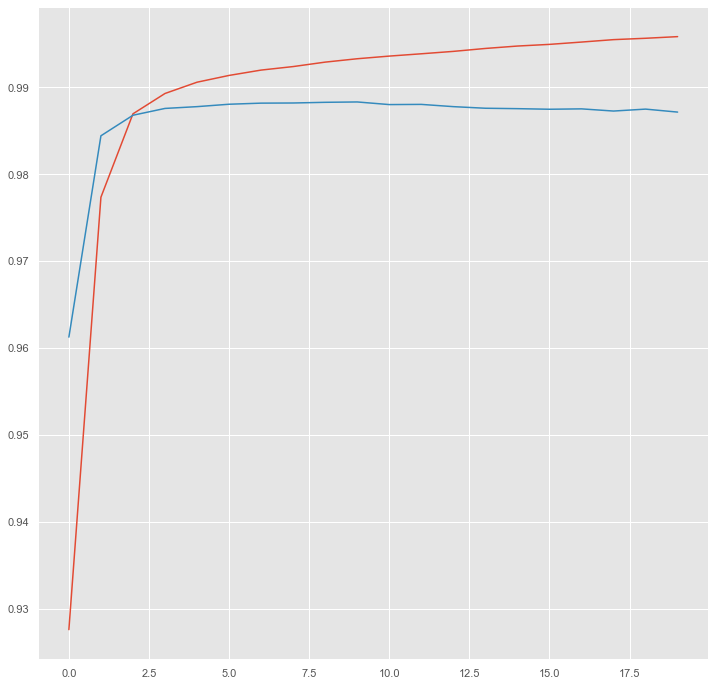

In [62]:

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [66]:
test_pred = model.predict(X_test, verbose=1)

7157/7157 [==============================] - ETA: 45 - ETA: 29 - ETA: 23 - ETA: 21 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

In [67]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [82]:
len(pred_labels[0])

70

In [68]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 83.4%


In [89]:
print(classification_report(np.argmax(test_pred, 2).ravel(), np.argmax(y_test, axis=2).ravel(), labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

         unk       0.00      0.00      0.00         0
           O       1.00      1.00      1.00    472878
       B-tim       0.89      0.89      0.89      3515
       B-gpe       0.95      0.97      0.96      2899
       B-org       0.68      0.82      0.74      2982
       B-geo       0.89      0.87      0.88      7186
       B-per       0.83      0.84      0.84      3197
       I-per       0.87      0.86      0.86      3368
       I-org       0.71      0.85      0.77      2598
       I-geo       0.80      0.79      0.79      1294
       B-art       0.08      0.38      0.13        16
       I-tim       0.72      0.77      0.74       962
       B-nat       0.19      0.71      0.30         7
       B-eve       0.23      0.42      0.30        26
       I-eve       0.14      0.19      0.16        26
       I-nat       0.00      0.00      0.00         1
       I-art       0.07      0.20      0.10        15
       I-gpe       0.50    

In [95]:
model.evaluate(X_test, np.array(y_test))

7157/7157 [==============================] - ETA: 20 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  

[-0.045051815682355625, 0.9877971410751343]

In [97]:
y_test

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],


In [105]:
i = 1444
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
truckload      : B-gpe B-gpe
evident        : O     O
Palin          : O     O
ITV1           : B-per B-per
Blantyre       : I-per I-per
responsible    : O     O
Joanne         : B-per B-per
rubies         : O     O
Diplomats      : O     O
rulers         : O     O
Susy           : O     O
exterminate    : O     O
Barghouti      : O     O
placed         : O     O
criminal       : O     O
scoop          : O     O
Terrorist      : O     O
dazed          : O     O
mockery        : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
assoc